**Table of contents**<a id='toc0_'></a>    
- [Preprocessing Utils](#toc1_)    
- [Search Engine Theory](#toc2_)    
  - [Preprocessing](#toc2_1_)    
  - [Inverted Index Construction](#toc2_2_)    
  - [TFIDF](#toc2_3_)    
  - [Cosine Similarity](#toc2_4_)    
- [Search Engine Practical](#toc3_)    
  - [Document Collection](#toc3_1_)    
  - [Inverted Index Construction](#toc3_2_)    
  - [Search Engine Feature](#toc3_3_)    
- [Text Classifier](#toc4_)    
  - [Get Training Data](#toc4_1_)    
  - [MultinomialNB classifier](#toc4_2_)    
  - [Metric Report](#toc4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [22]:
import pandas as pd
import json

import requests
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# <a id='toc1_'></a>[Preprocessing Utils](#toc0_)

In [23]:
def tokenizer(statement):
    # Filter out stop words & special characters
    stop_words = set(stopwords.words('english'))
    special_characters = '''!()-—[]{};:'"\, <>./?@#$%^&*_~+='''
    tokens = word_tokenize(statement)
    return [token.lower() for token in tokens if token.lower() not in stop_words and token not in special_characters]

def lemmatize_word(word):
    wordnet_tags = {"V": wordnet.VERB, "R": wordnet.ADV,"N": wordnet.NOUN,"J": wordnet.ADJ} 
    # Get parts of speech tag & determine the class in wordnet
    pos_tag = nltk.pos_tag([word])[0][1][0].upper()
    pos_tag_class = wordnet_tags.get(pos_tag, wordnet.NOUN)
    lemmatizer = WordNetLemmatizer()
    # Lemmaitze with Part of Speech Tag to get the pure word
    lemma = lemmatizer.lemmatize(word, pos=pos_tag_class)
    return lemma

def lemmatize_stmt(statement):    
    filtered_tokens = tokenizer(statement)
    lemmatize_tokens = []
    for word in filtered_tokens:
        lemma = lemmatize_word(word)
        lemmatize_tokens.append(lemma)
    return ' '.join(lemmatize_tokens)

# <a id='toc2_'></a>[Search Engine Theory](#toc0_)

## <a id='toc2_1_'></a>[Preprocessing](#toc0_)
Clean and preprocess the documents to remove any irrelevant information, such as HTML tags, punctuation, and stop words (common words like "the," "is," etc.). 

Additionally, perform other text normalization techniques like stemming or lemmatization to reduce words to their base form.

In [27]:
# Example
sample_title = "A phantom studies of a protective trolleys for neonatal radiographic imaging: new equipment to protect the operator from scatter radiating"
filtered_tokens = tokenizer(sample_title)
print('Tokenizer')
print(sample_title)
print(' '.join(filtered_tokens))
print()
print('Word & Lemma')
for word in filtered_tokens:
    lemma = lemmatize_word(word)
    print(word, '->', lemma)

Tokenizer
A phantom studies of a protective trolleys for neonatal radiographic imaging: new equipment to protect the operator from scatter radiating
phantom studies protective trolleys neonatal radiographic imaging new equipment protect operator scatter radiating

Word & Lemma
phantom -> phantom
studies -> study
protective -> protective
trolleys -> trolley
neonatal -> neonatal
radiographic -> radiographic
imaging -> image
new -> new
equipment -> equipment
protect -> protect
operator -> operator
scatter -> scatter
radiating -> radiate


## <a id='toc2_2_'></a>[Inverted Index Construction](#toc0_)
- Allow quick access to documents based on the terms they contain.
- Index optimization for space efficiency or query performance

In [116]:
# Example usage
documents = [
    "I like cats.",
    "I like dogs.",
    "I like birds."
]

inverted_index = {}
for doc_id, document in enumerate(documents):
    terms = document.lower().split() 
    for term in terms:
        if term not in inverted_index:
            inverted_index[term] = [] 
        inverted_index[term].append(doc_id)  

# Print the inverted index
for term, doc_ids in inverted_index.items():
    print(term, doc_ids)

i [0, 1, 2]
like [0, 1, 2]
cats. [0]
dogs. [1]
birds. [2]


## <a id='toc2_3_'></a>[TFIDF](#toc0_)
- numerical statistic that reflects the importance of a term in a document within a larger collection of documents.
- relative importance of each term within each document based on their TF-IDF scores.
- Higher TF-IDF values indicate more significant terms within the document corpus.

Example of TFIDF

In [113]:
documentA = 'the man went out for a walk'
documentB = 'the children sat around the fire'

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform([documentA, documentB])
feature_names = vectorizer.get_feature_names_out()
df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
df

,around,children,fire,for,man,out,sat,the,walk,went
0,0.000000,0.000000,0.000000,0.42616,0.42616,0.42616,0.000000,0.303216,0.42616,0.42616
1,0.407401,0.407401,0.407401,0.00000,0.00000,0.00000,0.407401,0.579739,0.00000,0.00000


## <a id='toc2_4_'></a>[Cosine Similarity](#toc0_)
It is the measurement that quantifies the similarity between two or more non-zero vectors

In [132]:
# Example usage
document1 = "Information Retrieval can be hard"
document2 = " Information Retrieval can be simple"

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform([document1, document2])

# Calculate the cosine similarity
similarity = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

similarity_score = similarity[0][0]
print("Similarity:", similarity_score)

Similarity: 0.6694188517266485


# <a id='toc3_'></a>[Search Engine Practical](#toc0_)

## <a id='toc3_1_'></a>[Document Collection](#toc0_)

In [ ]:
BASE_URL = 'https://pureportal.coventry.ac.uk/'
RCIH_publications = BASE_URL + 'en/organisations/centre-for-intelligent-healthcare/publications/'

print("Scraping")

research_output = []
url_path = RCIH_publications
while url_path is not None:
    print(".", end="")
    response = requests.get(url_path)
    soup = BeautifulSoup(response.content, "html.parser")
    li_item_tags = soup.find_all('li', class_= 'list-result-item')
    for li_item in li_item_tags:
        research_link = li_item.find('a')['href']
        authors = [{'author':author.text, 'url': author['href']} for author in li_item.findAll('a', 'link person')]
        published_date = li_item.find('span', class_='date').text
        title = li_item.find('h3', class_='title').text
        categories = [concept.text for concept in li_item.findAll('span', class_ = 'concept')]
        imp = lemmatize_stmt(title)  + ' ' + \
            " ".join([author['url'].split('/')[-1].replace('-', ' ') for author in authors]) + ' ' + \
                lemmatize_stmt(" ".join(categories)) + ' ' + \
            lemmatize_stmt(published_date)
        research_output.append({"authors":authors, "published_date":published_date, "title":title, "research_link": research_link, "categories": categories, "imp": imp})
    nextLinkTag = soup.find('a', class_ = 'nextLink')
    if nextLinkTag is not None:
        url_path = BASE_URL+nextLinkTag['href']
    else:
        url_path = None
print('\nTotal Document Scrapped:', len(research_output))

In [ ]:
# Dump scraped data to json file
with open('./scraped_data/rcih_research_output.json', 'w') as f:
    json.dump(research_output, f, indent=4)

## <a id='toc3_2_'></a>[Inverted Index Construction](#toc0_)

In [24]:
inverted_index = {}
with open('./scraped_data/rcih_research_output.json') as f:
    rcih_research = json.loads(f.read())

for doc_id, doc in enumerate(rcih_research):
    imp = lemmatize_stmt(doc['title']  + ' ' + " ".join(doc['categories']) + ' ' + doc['published_date']) + ' ' + \
            " ".join([author['url'].split('/')[-1].replace('-', ' ') for author in doc['authors']])
    for term in imp.split():
        if term not in inverted_index:
            inverted_index[term] = set()
        inverted_index[term].add(doc_id)

# Converting Set to List
for key in inverted_index:
    inverted_index[key] = list(inverted_index[key])

with open('./scraped_data/inverted_index.json', 'w') as f:
    json.dump(inverted_index, f, indent=4)

## <a id='toc3_3_'></a>[Search Engine Feature](#toc0_)

In [117]:
query = 'ioannis kyrou COVID-19 Diabetes'
lemmatized_query = [lemmatize_stmt(query)]

In [118]:
with open('./scraped_data/inverted_index.json') as f:
    inverted_index = json.loads(f.read())
with open('./scraped_data/rcih_research_output.json') as f:
    rcih_research = json.loads(f.read())

In [133]:
# Get Documents from Inverted Index
token_docs_set = set()
for query_token in lemmatized_query[0].split():
    token_docs = inverted_index[query_token]
    token_docs_set.update(token_docs)
sorted_token_docs_set = sorted(token_docs_set)

processed_research = []
for doc_id in sorted_token_docs_set:
    processed_research.append(rcih_research[doc_id])

df = pd.DataFrame.from_dict(processed_research)

In [126]:
vectorizer = TfidfVectorizer()
document_vectors = vectorizer.fit_transform(df['imp'])
query_vector = vectorizer.transform(lemmatized_query)

# Calculate cosine similarity between search query and documents
cosine_similarities = cosine_similarity(query_vector, document_vectors).flatten()
# Sort the documents based on cosine similarity scores
sorted_indices = cosine_similarities.argsort()[::-1]
for i in range(10):
    index = sorted_indices[i]
    relevant_document = df.iloc[index]
    relevance_score = round(cosine_similarities[index] * 100,2)
    print('Position', i+1)
    print('Relevance Score:', relevance_score, '%' )
    print('Title:', relevant_document["title"])
    print('Authors:', ' | '.join([author['author'] for author in relevant_document['authors']]))
    print('Categories:', ' | '.join([category for category in relevant_document['categories']]))
    print('----------------------------------------')

Position 1
Relevance Score: 27.84 %
Title: Digitally enabled flash glucose monitoring for inpatients with COVID-19: Feasibility and pilot implementation in a teaching NHS Hospital in the UK
Authors: Clark, C. C. T. | Kyrou, I.
Categories: Inpatient | Glucose | COVID-19 | Monitoring | Hemoglobin A1c
----------------------------------------
Position 2
Relevance Score: 25.17 %
Title: Healthcare staff perceptions following inoculation with the BNT162b2 mRNA COVID-19 vaccine at University Hospitals Coventry & Warwickshire NHS trust
Authors: Kyrou, I. | Clark, C.
Categories: COVID-19 | Vaccine | Perception | Messenger RNA | Side Effect
----------------------------------------
Position 3
Relevance Score: 21.6 %
Title: Potential metabolic and inflammatory pathways between COVID-19 and new-onset diabetes
Authors: Tapp, R.
Categories: COVID-19 | Diabetes | Diabetes Mellitus | Severe Acute Respiratory Syndrome Coronavirus 2
----------------------------------------
Position 4
Relevance Score: 21.2

# <a id='toc4_'></a>[Text Classifier](#toc0_)
Identify whether the input scientific document is from the listed cases: 
- Health
- Business
- Sport

Training Data link : https://www.kaggle.com/datasets/rmisra/news-category-dataset

## <a id='toc4_1_'></a>[Get Training Data](#toc0_)

In [4]:
news_df = pd.read_json('News_Category_Dataset_v3.json', lines=True)

In [7]:
training_news_df = news_df[news_df['category'].isin(['BUSINESS', "SPORTS", "HEALTHY LIVING"])]
training_news_df.loc[training_news_df['category']== "HEALTHY LIVING" , 'category'] = "HEALTH"
training_news_df = training_news_df[['short_description', 'category']]
training_news_df['short_description'] = training_news_df['short_description'].apply(lemmatize_stmt)
training_news_df.to_pickle("training_news_df.pkl")

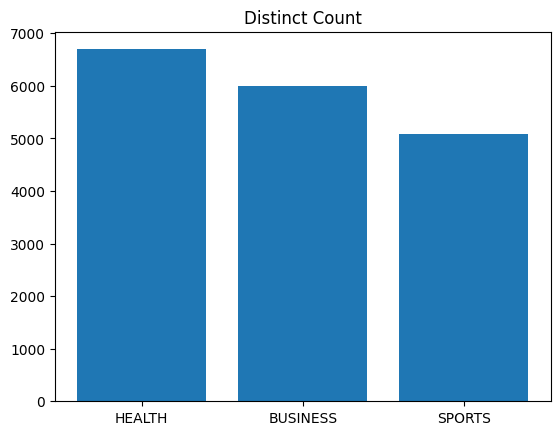

In [8]:
import matplotlib.pyplot as plt

value_counts = training_news_df['category'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.title('Distinct Count')
plt.show()

## <a id='toc4_2_'></a>[MultinomialNB classifier](#toc0_)

In [20]:
training_news_df = pd.read_pickle('training_news_df.pkl')

# Sample training data
texts = training_news_df['short_description'].tolist()
labels = training_news_df['category'].tolist()
# Create feature vectors
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)
classifier = MultinomialNB()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

test_texts = ["""
They fell short in what was virtually a must-win game, with the added significance of being on free-to-air television and with the opportunity to make their mark on the eager crowd that roared and applauded every England run and wicket with vigour.

And they felt the disappointment, too - but there was a bigger picture.

Ten years ago to the day, Nat Sciver-Brunt made her England debut against Pakistan at Louth, where spectators were few and far between and most likely consisted mostly of the players' families.

But for England's debutant at Edgbaston, all-rounder Danielle Gibson, the experience could not be more of a contrast - and in the most brilliant, inspiring way.

Gibson was clapped in to bowl like an Olympic long jumper at the start of their mark, each dot ball cheered like a wicket and every run saved greeted with raucous appreciation.

There was diversity in numbers, too - children danced for the camera, groups of friends dressed up as Super Mario and lifeguards, boys donning England shirts with 'Knight' and 'Sciver-Brunt' on the back.

As England fought back in the closing overs with three late wickets to ignite hopes of a shock victory, the crowd savoured every emotion with them.
"""]
test_X = vectorizer.transform(test_texts)
test_predictions = classifier.predict(test_X)
print('Predictions:', test_predictions)

Training Complete


## <a id='toc4_3_'></a>[Metric Report](#toc0_)

Evaluate the performance of classification models.

In [19]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report

# Test the classifier on training data
train_predictions = classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
print('Training Accuracy:', train_accuracy)

# Test the classifier on testing data
test_predictions = classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Testing Accuracy:', test_accuracy)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

# Calculate the F1 score
f1 = f1_score(y_test, test_predictions, average='weighted')
print('F1 Score:', f1)

# Print classification report
class_report = classification_report(y_test, test_predictions)
print('\nClassification Report:')
print(class_report)

Training Accuracy: 0.802603800140746
Testing Accuracy: 0.7261469180973825
F1 Score: 0.7249536376495858

Classification Report:
              precision    recall  f1-score   support

    BUSINESS       0.80      0.66      0.72      1197
      HEALTH       0.64      0.86      0.74      1350
      SPORTS       0.84      0.62      0.71      1006

    accuracy                           0.73      3553
   macro avg       0.76      0.71      0.72      3553
weighted avg       0.75      0.73      0.72      3553



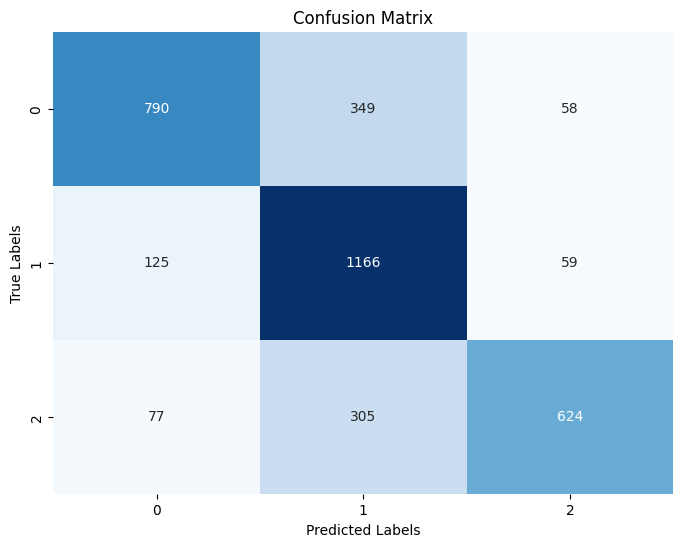

In [15]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()